In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec

import random
import scikitplot as skplot
import matplotlib.pyplot as plt

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:
#https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

#url = "nflx.csv"
#url="dpz.csv"
url="PYPL.csv"

df = pd.read_csv(url)

df.columns = [x.lower() for x in df.columns]
#print(df.head())
df=df.sort_values(by="date")
df=df.reset_index()

df=df.drop(["high","low","adj close"],axis=1)
print(df.columns)

df['open_pct_change']=df['open'].pct_change()

print(df["open_pct_change"])

df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    #print(df.iloc[index])
    count=0
    for index2 in (range(index,0,-1)):
        #print(df.iloc[index2]["open_pct_change"])
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
            #print("found",count)
        else:
            break
    #print("count",count)
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    #print("new",df.iloc[index]["pct_pos_count"])
    
print(df[df["open_pct_positive_count"]>0])    



Index(['index', 'date', 'open', 'close', 'volume'], dtype='object')
0           NaN
1     -0.007935
2     -0.000482
3      0.014366
4      0.005893
         ...   
248   -0.007138
249   -0.010529
250    0.007266
251    0.011681
252   -0.004899
Name: open_pct_change, Length: 253, dtype: float64
     index        date        open       close    volume  open_pct_change  \
3        3  2019-12-12  105.209999  105.669998   6379500         0.014366   
4        4  2019-12-13  105.830002  107.650002   6998800         0.005893   
5        5  2019-12-16  108.400002  109.570000   8465400         0.024284   
6        6  2019-12-17  109.570000  108.459999   8165900         0.010793   
9        9  2019-12-20  109.279999  108.750000   9823200         0.013729   
..     ...         ...         ...         ...       ...              ...   
244    244  2020-11-25  206.289993  214.460007  13817500         0.011225   
245    245  2020-11-27  213.199997  211.389999   5363200         0.033497   
247    247  

[Timestamp('2019-12-16 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-02-19 00:00:00'), Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-18 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('2020-07-21 00:00:00'), Timestamp('2020-07-29 00:00:00'), Timestamp('2020-08-07 00:00:00'), Timestamp('2020-09-29 00:00:00'), Timestamp('2020-10-14 00:00:00'), Timestamp('2020-11-06 00:00:00'), Timestamp('2020-11-24 00:00:00')]


(array([737425., 737485., 737546., 737607., 737669., 737730.]),
 <a list of 6 Text xticklabel objects>)

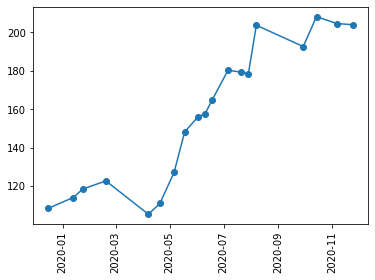

In [50]:
####### if the occurrences were greater than 2, did the pct change stay positive

df["target"]=0
for index in range(len(df)):
    pct_chg=df.iloc[index]["open_pct_change"]
    if index!=0:
        prior_pct_chg_count=df.iloc[index-1]["open_pct_positive_count"]
        if (prior_pct_chg_count>=2) & (pct_chg>0):
             df.iloc[index, df.columns.get_loc('target')]=1
        
buy_list=df[df["target"]==1]
previous=-1
buy={}
for index,item in buy_list.iterrows():
    #print(item["date"],item["open"],item["open_pct_positive_count"])
    if item["open_pct_positive_count"]<=previous or previous==-1:
        key=pd.to_datetime(item["date"])
        value=item['open']
        buy.update({key: value})
        #print(item["date"],item["open"],item["open_pct_positive_count"])
    previous=item["open_pct_positive_count"]
    
x=list(buy.keys())
print(x)
y=list(buy.values())
#plt.plot(x=x,y=y)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot_date(x, y, ls='-', marker='o')
plt.xticks(rotation=90)    

   open_pct_positive_count  Incidence  Size
0                        0          0   109
1                        1          0    67
2                        2          0    42
3                        3          1    19
4                        4          1    11
5                        5          1     4
6                        6          1     1
19
incidence show the average target value for each group


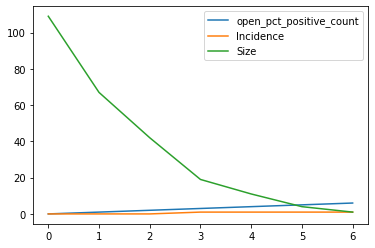

     index        date        open       close    volume  open_pct_change  \
0        0  2019-12-09  104.599998  103.779999   5641300              NaN   
1        1  2019-12-10  103.769997  103.620003   5316500        -0.007935   
2        2  2019-12-11  103.720001  105.510002   5779700        -0.000482   
7        7  2019-12-18  108.860001  107.830002   6477900        -0.006480   
8        8  2019-12-19  107.800003  108.879997   6590000        -0.009737   
..     ...         ...         ...         ...       ...              ...   
240    240  2020-11-19  190.820007  190.899994   9391500        -0.009190   
246    246  2020-11-30  212.509995  214.119995  12976100        -0.003236   
248    248  2020-12-02  215.600006  212.559998   7537400        -0.007138   
249    249  2020-12-03  213.330002  214.539993   7645200        -0.010529   
252    252  2020-12-08  216.324997  217.003403   1523411        -0.004899   

     open_pct_positive_count  target  
0                          0       0

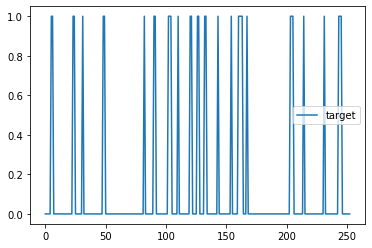

In [4]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)

print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()
#(df["open_pct_pos_count"]==4)&
print(df[(df["target"]==0)&(df["open_pct_positive_count"]==0)])

df.plot(y="target")  #buy
plt.show()


In [5]:
#X = df.drop(["date","target"], axis = 1)
#y = df["target"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 42)
timeSteps=30
#X_train = np.resize(X_train,(X_train.shape[0],timeSteps,X_train.shape[1]))


train_split= 0.9
split_idx = int(len(X) * 0.9)
training_set = df[:split_idx].values
test_set = df[split_idx:].values


n_future=5
n_past=30


X_train , y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))

pct_chg_column=4
X_test = test_set[: n_past, pct_chg_column]
#print(X_test)

target_column=6
#n_past : n_past + n_future
print(n_past + n_future)
y_test = test_set[n_past + n_future, target_column]
print(y_test)

#convert to an array
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))



samples=X_train.shape[0]

features=len(X.columns)

NameError: name 'X' is not defined

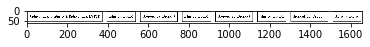

In [105]:
#1. The LSTM input layer must be 3D.
#2. The meaning of the 3 input dimensions are: samples, time steps, and features.
#3. The LSTM input layer is defined by the input_shape argument on the first hidden layer.
#4. The input_shape argument takes a tuple of two values that define the number of time steps and features.
#5. The number of samples is assumed to be 1 or more.

#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

#input layer expects a 3D array of data when fitting the model and when making predictions, 
#even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

#The input shape is supposed in the format (no_of_samples,no_of_timesteps,features)

#The input to every LSTM layer must be three-dimensional.
# expected input data shape: (batch_size, timesteps, data_dim)

n_future = 1
model = Sequential()

model.add(Bidirectional(LSTM(units=30, return_sequences=True, 
                             input_shape=(timeSteps, features))))

#old -- model.add(LSTM(30, activation='sigmoid', return_sequences=True,
#              input_shape=(timeSteps, features)))  # returns a sequence of vectors of dimension 

#model.add(LSTM(features, activation='sigmoid', return_sequences=True))  # returns a sequence of vectors of dimension 
#model.add(LSTM(30, activation='sigmoid'))  # return a single vector of dimension 
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

model.add(LSTM(units= features, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= features, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= features))
model.add(Dropout(0.2))
model.add(Dense(units = n_future, activation="relu"))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()



In [106]:
model.fit(X_train, np.array(y_train),epochs=500, batch_size=32  )

Epoch 1/500
170/170 [==============================] - 2s 9ms/step - loss: nan - acc: 0.1176
Epoch 2/500
170/170 [==============================] - 0s 701us/step - loss: nan - acc: 0.0000e+00
Epoch 3/500
170/170 [==============================] - 0s 696us/step - loss: nan - acc: 0.0000e+00
Epoch 4/500
170/170 [==============================] - 0s 628us/step - loss: nan - acc: 0.0000e+00
Epoch 5/500
170/170 [==============================] - 0s 764us/step - loss: nan - acc: 0.0000e+00
Epoch 6/500
170/170 [==============================] - 0s 672us/step - loss: nan - acc: 0.0000e+00
Epoch 7/500
170/170 [==============================] - 0s 607us/step - loss: nan - acc: 0.0000e+00
Epoch 8/500
170/170 [==============================] - 0s 698us/step - loss: nan - acc: 0.0000e+00
Epoch 9/500
170/170 [==============================] - 0s 815us/step - loss: nan - acc: 0.0000e+00
Epoch 10/500
170/170 [==============================] - 0s 786us/step - loss: nan - acc: 0.0000e+00
Epoch 11/500
17

170/170 [==============================] - 0s 716us/step - loss: nan - acc: 0.0000e+00
Epoch 164/500
170/170 [==============================] - 0s 969us/step - loss: nan - acc: 0.0000e+00
Epoch 165/500
170/170 [==============================] - 0s 829us/step - loss: nan - acc: 0.0000e+00
Epoch 166/500
170/170 [==============================] - 0s 866us/step - loss: nan - acc: 0.0000e+00
Epoch 167/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 168/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 169/500
170/170 [==============================] - 0s 629us/step - loss: nan - acc: 0.0000e+00
Epoch 170/500
170/170 [==============================] - 0s 701us/step - loss: nan - acc: 0.0000e+00
Epoch 171/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 172/500
170/170 [==============================] - 0s 698us/step - loss: nan - acc: 0.0000e+00
Epoc

170/170 [==============================] - 0s 654us/step - loss: nan - acc: 0.0000e+00
Epoch 324/500
170/170 [==============================] - 0s 696us/step - loss: nan - acc: 0.0000e+00
Epoch 325/500
170/170 [==============================] - 0s 625us/step - loss: nan - acc: 0.0000e+00
Epoch 326/500
170/170 [==============================] - 0s 716us/step - loss: nan - acc: 0.0000e+00
Epoch 327/500
170/170 [==============================] - 0s 604us/step - loss: nan - acc: 0.0000e+00
Epoch 328/500
170/170 [==============================] - 0s 724us/step - loss: nan - acc: 0.0000e+00
Epoch 329/500
170/170 [==============================] - 0s 742us/step - loss: nan - acc: 0.0000e+00
Epoch 330/500
170/170 [==============================] - 0s 675us/step - loss: nan - acc: 0.0000e+00
Epoch 331/500
170/170 [==============================] - 0s 791us/step - loss: nan - acc: 0.0000e+00
Epoch 332/500
170/170 [==============================] - 0s 648us/step - loss: nan - acc: 0.0000e+00
Epoc

170/170 [==============================] - 0s 827us/step - loss: nan - acc: 0.0000e+00
Epoch 486/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 487/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 488/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 489/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 490/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 491/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 492/500
170/170 [==============================] - 0s 643us/step - loss: nan - acc: 0.0000e+00
Epoch 493/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 494/500
170/170 [==============================] - 0s 863us/step - loss: nan - acc: 0.0000e+00
Epoc

In [108]:
prediction = model.predict(X_test)
print('Predicted {}'.format(prediction))
print('Real {}'.format(y_test))

ValueError: Error when checking input: expected sequential_12_input to have 3 dimensions, but got array with shape (84, 5)